In [1]:
import torch
import numpy as np
import json


import torch.nn as nn
import torch.utils.data as Data


import torchvision.utils 
import torchvision.datasets as Datasets
import torchvision.transforms as transforms
from torchvision import models


import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline



## Importing the class labels from json file

In [2]:
##loading the classlabels along with index and labels
classids=json.load(open("./data/imagenet_class_index.json"))
##contains the labels in the list
id_to_label=[classids[str(k)][1]for k in range(len(classids))]


##transforms definer
transform=transforms.Compose([transforms.Resize((299,299)),transforms.ToTensor()])

In [3]:
def image_data_retriever(root,transform,custom_label):
    old_data=Datasets.ImageFolder(root=root,transform=transform)
    old_classes=old_data.classes

    label_to_id={}

    for i,data in enumerate(id_to_label):
        label_to_id[id_to_label[i]]=i
    
    new_data=Datasets.ImageFolder(root,transform,target_transform=lambda x:label_to_id[old_classes[x]])
    new_data.classes=id_to_label
    new_data.class_to_idx=label_to_id

    return new_data

In [4]:
train_data=image_data_retriever("./data/",transform,id_to_label)
train__data_loader=Data.DataLoader(train_data,batch_size=1,shuffle=False)

## Displaying the image and its label

In [5]:
def imshow(image,title):
    npimg=image.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

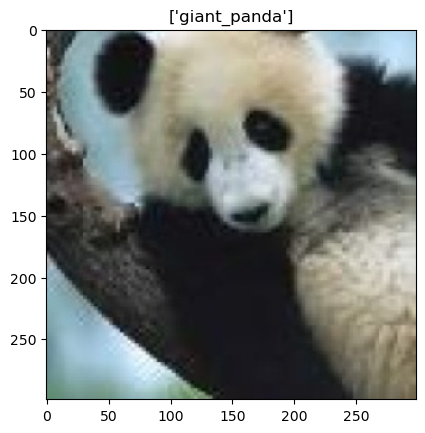

In [6]:
train_iter=iter(train__data_loader)
images,labels=next(train_iter)

imshow(torchvision.utils.make_grid(images, normalize=True),[id_to_label[labels]])

## Importing a model and testing the output label

/home/lenovo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/lenovo/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


tensor(9.0584)


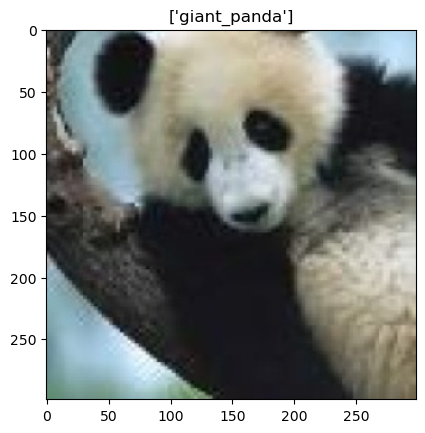

Accuracy of the test :100 %


In [7]:
device=torch.device("cpu")
model=models.inception_v3(pretrained=True).to(device)

model.eval()
correct=0
total=0

for images,labels in train__data_loader:
    images=images.to(device)
    labels=labels.to(device)
    outputs=model(images)
    output_confidence,output_labels=torch.max(outputs.data,1)
    total+=images.shape[0]
    print(output_confidence[0])
    correct+=(output_labels==labels).sum()
    imshow(torchvision.utils.make_grid(images, normalize=True),[id_to_label[output_labels]])

print('Accuracy of the test :%d %%'% (100*correct/float(total)))


## FGSM attack:

torch.Size([1, 1000])
tensor(8.3810)


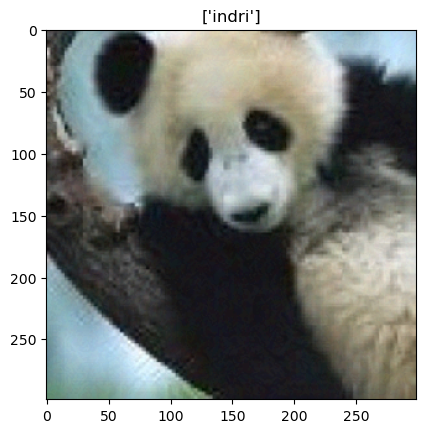

Accuracy of the  model after attack is: 0.000000 %


In [8]:
eps=0.01
loss=nn.CrossEntropyLoss()

def fgsm_attack(images,labels):
    images=images.to(device)
    labels=labels.to(device)
    images.requires_grad=True
    outputs=model(images)
    model.zero_grad()
    cost=loss(outputs,labels).to(device)
    cost.backward()
    attack_images=images+eps*images.grad.sign()
    attack_images=torch.clamp(attack_images,0,1)
    return attack_images


total =0
correct=0
for images,labels in train__data_loader:
    #images=images.to(device)
    labels=labels.to(device)
    attacked_images=fgsm_attack(images,labels).to(device)

    outputs=model(attacked_images)
    print(outputs.shape)
    output_confidence,output_labels=torch.max(outputs.data,1)
    print(output_confidence[0])
    total+=images.shape[0]
    correct+=(labels==output_labels).sum()
    imshow(torchvision.utils.make_grid(attacked_images,normalize=True),[id_to_label[output_labels]])

print("Accuracy of the  model after attack is: %f %%"%(100*float(correct)/total))

## CW attack

Attack Stopped due to CONVERGENCE....
torch.Size([1, 1000])
tensor(8.7837)


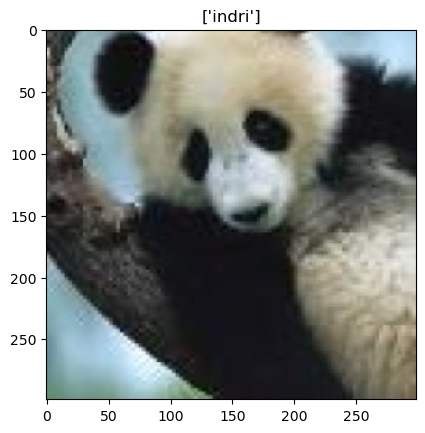

Accuracy of the  model after attack is: 0.000000 %


In [13]:


import torch.optim as optim

def f(x,kappa,targeted) :
        outputs = model(x)
        one_hot_labels = torch.eye(len(outputs[0]))[labels].to(device)
        i, _ = torch.max((1-one_hot_labels)*outputs, dim=1)
        j = torch.masked_select(outputs, one_hot_labels.bool())
        if targeted :
            return torch.clamp(i-j, min=-kappa)
        else :
             return torch.clamp(j-i, min=-kappa)


def cw_attack(model, images, labels, targeted=False, c=1e-4, kappa=0, max_iter=1000, learning_rate=0.1) :
    images = images.to(device)     
    labels = labels.to(device)
    w = torch.zeros_like(images, requires_grad=True).to(device)
    optimizer = optim.Adam([w], lr=learning_rate)
    prev = 1e10
    for i in range(max_iter) :
        image1 = 1/2*(nn.Tanh()(w) + 1)
        loss1 = nn.MSELoss(reduction='sum')(image1, images)
        loss2 = torch.sum(c*f(image1,kappa,targeted))
        cost = loss1 + loss2
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        # Early Stop when loss does not converge.
        if i % (max_iter//10) == 0 :
            if cost > prev :
                return image1
            prev = cost
    attack_images = 1/2*(nn.Tanh()(w) + 1)
    return attack_images




model.eval()
total =0
correct=0
for images,labels in train__data_loader:
    #images=images.to(device)
    labels=labels.to(device)
    attacked_images= cw_attack(model, images, labels, targeted=False, c=0.1)

    outputs=model(attacked_images)
    print(outputs.shape)
    output_confidence,output_labels=torch.max(outputs.data,1)
    print(output_confidence[0])
    total+=images.shape[0]
    correct+=(labels==output_labels).sum()
    imshow(torchvision.utils.make_grid(attacked_images,normalize=True),[id_to_label[output_labels]])

print("Accuracy of the  model after attack is: %f %%"%(100*float(correct)/total))

## Deepfool attack

In [11]:

# model=models.resnet34(pretrained=True).to(device)
# import math
# import copy
# import os
# model.eval()
# def deepfool_attack(images, labels, max_iter=50, epsilon=0.0012):
#     images = images.to(device)
#     labels = labels.to(device)
#     images.requires_grad = True

#     # Get the model's prediction and initial perturbation
#     outputs = model(images)
#     _, predicted = torch.max(outputs.data, 1)
    
#     # Start DeepFool attack
#     perturbed_images = images

#     perturbed_images.requires_grad = True
#     for _ in range(max_iter):
#         outputs = model(perturbed_images)
#         _, predicted = torch.max(outputs.data, 1)
#         print(predicted.data,labels.data)
        
#         if torch.all(predicted != labels):
#             break
#         loss = F.cross_entropy(outputs, labels)
#         model.zero_grad()
#         loss.backward()
#         # if perturbed_images.grad is None:
#         #     raise ValueError("Gradients were not computed.")
        
#         grad = perturbed_images.grad
#         perturbation = grad.sign() * epsilon
#         perturbed_images = perturbed_images + perturbation
#         perturbed_images = torch.clamp(perturbed_images, 0, 1)
    
#     return perturbed_images

# import torch.optim as optim
# def deepfool(image, net, num_classes=1000, overshoot=0.02, max_iter=10):

#     f_image = net.forward(image).data.numpy().flatten()
#     I = (np.array(f_image)).flatten().argsort()[::-1]

#     I = I[0:num_classes]
#     label = I[0]

#     input_shape = image.detach().numpy().shape
#     pert_image = copy.deepcopy(image)
#     w = np.zeros(input_shape)
#     r_tot = np.zeros(input_shape)

#     loop_i = 0

#     x = torch.tensor(pert_image[None, :],requires_grad=True)
    
#     fs = net.forward(x[0])
#     fs_list = [fs[0,I[k]] for k in range(num_classes)]
#     k_i = label

#     while k_i == label and loop_i < max_iter:

#         pert = np.inf
#         fs[0, I[0]].backward(retain_graph=True)
#         grad_orig = x.grad.data.numpy().copy()

#         for k in range(1, num_classes):
            
#             #x.zero_grad()
            
#             fs[0, I[k]].backward(retain_graph=True)
#             cur_grad = x.grad.data.numpy().copy()

#             # set new w_k and new f_k
#             w_k = cur_grad - grad_orig
#             f_k = (fs[0, I[k]] - fs[0, I[0]]).data.numpy()

#             pert_k = abs(f_k)/np.linalg.norm(w_k.flatten())

#             # determine which w_k to use
#             if pert_k < pert:
#                 pert = pert_k
#                 w = w_k

#         # compute r_i and r_tot
#         # Added 1e-4 for numerical stability
#         r_i =  (pert+1e-4) * w / np.linalg.norm(w)
#         r_tot = np.float32(r_tot + r_i)

#         pert_image = image + (1+overshoot)*torch.from_numpy(r_tot)

#         x = torch.tensor(pert_image, requires_grad=True)
#         fs = net.forward(x[0])
#         k_i = np.argmax(fs.data.numpy().flatten())

#         loop_i += 1
#         print(loop)

#     r_tot = (1+overshoot)*r_tot

#     return pert_image

# # import torch.nn.functional as F